# Start-to-Finish Example: Numerical Solution of the Scalar Wave Equation, in Cartesian Coordinates

<font color='green'>**This module has been validated to converge at the expected order to the exact solution (see plot at bottom).**</font>

### NRPy+ Source Code for this module: [ScalarWave/ScalarWave_RHSs.py](../edit/ScalarWave/ScalarWave_RHSs.py); [ScalarWave/InitialData_PlaneWave.py](../edit/ScalarWave/InitialData_PlaneWave.py)

As outlined in the [previous NRPy+ tutorial module](Tutorial-ScalarWave.ipynb), we first use NRPy+ to generate initial data for the scalar wave equation, and then we use it to generate the RHS expressions for [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on the [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4).

The entire algorithm is outlined below, with NRPy+-based components highlighted in <font color='green'>green</font>.

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. <font color='green'>Set gridfunction values to initial data.</font>
1. Evolve the system forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. <font color='green'>Evaluate scalar wave RHS expressions.</font>
    1. Apply boundary conditions.
1. At the end of each iteration in time, output the relative error between numerical and exact solutions.

### Generating the NRPy+ Components to the Scalar Wave Equation in Three Spatial Dimensions, Fourth-Order Finite Differencing, with Monochromatic Plane Wave Initial Data

Let's pick up where we left off in the [previous module](Tutorial-ScalarWave.ipynb), interfacing with the ScalarWave/ module to generate 
* monochromatic (single-wavelength) plane wave scalar wave initial data, and
* the scalar wave equation RHSs at **4th** finite difference order in **3 spatial dimensions**

In [1]:
# Step P1: Import needed NRPy+ core modules:
import NRPy_param_funcs as par
import indexedexp as ixp
import grid as gri
import finite_difference as fin
import loop as lp
from outputC import *

# Step 1: Import the ScalarWave.InitialData module. 
#         This command only declares ScalarWave initial data 
#         parameters and the InitialData_PlaneWave() function.
import ScalarWave.InitialData_PlaneWave as swid

# Step 2: Import ScalarWave_RHSs module. 
#         This command only declares ScalarWave RHS parameters
#         and the ScalarWave_RHSs function (called later)
import ScalarWave.ScalarWave_RHSs as swrhs

# Step 3: Set the spatial dimension parameter 
#         to *FOUR* this time, and then read
#         the parameter as DIM.
par.set_parval_from_str("grid::DIM",3)
DIM = par.parval_from_str("grid::DIM")

# Step 4: Set the finite differencing order to 4.
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER",4)

# Step 5: Call the InitialData_PlaneWave() function to set up
#         monochromatic (single frequency/wavelength) scalar
#         wave initial data.
swid.InitialData_PlaneWave()

# Step 6: Generate SymPy symbolic expressions for
#         uu_rhs and vv_rhs; the ScalarWave RHSs.
#         This function also declares the uu and vv
#         gridfunctions, which need to be declared
#         to output even the initial data to C file.
swrhs.ScalarWave_RHSs()

# Step 7: Generate C code for the initial data,
#         output to a file named "SENR/ScalarWave_InitialData.h".
IDstring = fin.FD_outputC("returnstring",[lhrh(lhs=gri.gfaccess("in_gfs","uu"),rhs=swid.uu_ID),
                                          lhrh(lhs=gri.gfaccess("in_gfs","vv"),rhs=swid.vv_ID)])
with open("ScalarWave/ScalarWave_ExactSolution.h", "w") as file:
    file.write(lp.loop(["i2","i1","i0"],["0","0","0"],
                       ["Nxx_plus_2NGHOSTS[2]","Nxx_plus_2NGHOSTS[1]","Nxx_plus_2NGHOSTS[0]"],["1","1","1"],
                       ["#pragma omp parallel for","    const REAL xx2=xx[2][i2];",
                        "        const REAL xx1=xx[1][i1];"],"",
                        "const REAL xx0=xx[0][i0];\n"+IDstring))

# Step 8: Generate C code for scalarwave RHSs,
#         output to a file named "SENR/ScalarWave_RHSs.h".
RHSstring = fin.FD_outputC("returnstring",[lhrh(lhs=gri.gfaccess("rhs_gfs","uu"),rhs=swrhs.uu_rhs),
                                           lhrh(lhs=gri.gfaccess("rhs_gfs","vv"),rhs=swrhs.vv_rhs)])
with open("ScalarWave/ScalarWave_RHSs.h", "w") as file:
    file.write(lp.loop(["i2","i1","i0"],["NGHOSTS","NGHOSTS","NGHOSTS"],
                       ["NGHOSTS+Nxx[2]","NGHOSTS+Nxx[1]","NGHOSTS+Nxx[0]"],
                       ["1","1","1"],["const REAL invdx0 = 1.0/dxx[0];\n"+
                                      "const REAL invdx1 = 1.0/dxx[1];\n"+
                                      "const REAL invdx2 = 1.0/dxx[2];\n"+
                                      "#pragma omp parallel for","",""],"",RHSstring))

## Basic C Code Infrastructure

Next we will write the C code infrastructure necessary to make use of the above NRPy+-generated codes. Again, we'll be using RK4 time integration via the Method of Lines.

In [2]:
# Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
with open("ScalarWave/ScalarWave_Playground.c", "w") as file:
    file.write("// Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER\n")
    file.write("#define NGHOSTS "+str(int(par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER")/2))+"\n")

In [3]:
%%writefile -a ScalarWave/ScalarWave_Playground.c

const int NSKIP_2D_OUTPUT = 5;

// Part P1: Import needed header files
#include "stdio.h"
#include "stdlib.h"
#include "math.h"

// Part P2: Add needed #define's to set data type, the IDX4() macro, and the gridfunctions
// Part P2a: set REAL=double, so that all floating point numbers are stored to at least ~16 significant digits.
#define REAL double
// Part P2b: Declare the IDX4(gf,i,j,k) macro, which enables us to store 4-dimensions of
//           data in a 1D array. In this case, consecutive values of "i" 
//           (all other indices held to a fixed value) are consecutive in memory, where 
//           consecutive values of "j" (fixing all other indices) are separated by 
//           Nxx_plus_2NGHOSTS[0] elements in memory. Similarly, consecutive values of
//           "k" are separated by Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1] in memory, etc.
#define IDX4(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * ( (k) + Nxx_plus_2NGHOSTS[2] * (g) ) ) )
// Part P2c: Set UUGF and VVGF macros
#define NUM_GFS 2
#define UUGF 0
#define VVGF 1

// Step P3: Set free parameters for the initial data
const REAL wavespeed = 1.0;
const REAL kk0 = 1.0;
const REAL kk1 = 1.0;
const REAL kk2 = 1.0;

// Part P4: Declare the function for the exact solution. time==0 corresponds to the initial data.
void exact_solution(const int Nxx_plus_2NGHOSTS[3],const REAL time,REAL *xx[3], REAL *in_gfs) {
#include "ScalarWave_ExactSolution.h"
}

// Part P5: Declare the function to evaluate the scalar wave RHSs
void rhs_eval(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3], const REAL *in_gfs, REAL *rhs_gfs) {
#include "ScalarWave_RHSs.h"
}

// Part P6: Declare boundary condition FACE_UPDATE macro,
//          which updates a single face of the 3D grid cube
//          using quadratic polynomial extrapolation.
const int MAXFACE = -1;
const int NUL     = +0;
const int MINFACE = +1;
#define  FACE_UPDATE(which_gf, i0min,i0max, i1min,i1max, i2min,i2max, FACEX0,FACEX1,FACEX2) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) { \
        gfs[IDX4(which_gf,i0,i1,i2)] =                                  \
          +3.0*gfs[IDX4(which_gf,i0+1*FACEX0,i1+1*FACEX1,i2+1*FACEX2)]  \
          -3.0*gfs[IDX4(which_gf,i0+2*FACEX0,i1+2*FACEX1,i2+2*FACEX2)]  \
          +1.0*gfs[IDX4(which_gf,i0+3*FACEX0,i1+3*FACEX1,i2+3*FACEX2)]; \
      }

// Part P7: Boundary condition driver routine: Apply BCs to all six
//          boundary faces of the cube, filling in the innermost
//          ghost zone first, and moving outward.
void apply_bcs(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],REAL *gfs) {
#pragma omp parallel for
    for(int which_gf=0;which_gf<NUM_GFS;which_gf++) {
    int imin[3] = { NGHOSTS, NGHOSTS, NGHOSTS };
    int imax[3] = { Nxx_plus_2NGHOSTS[0]-NGHOSTS, Nxx_plus_2NGHOSTS[1]-NGHOSTS, Nxx_plus_2NGHOSTS[2]-NGHOSTS };
    for(int which_gz = 0; which_gz < NGHOSTS; which_gz++) {
      // After updating each face, adjust imin[] and imax[] 
      //   to reflect the newly-updated face extents.
      FACE_UPDATE(which_gf, imin[0]-1,imin[0], imin[1],imax[1], imin[2],imax[2], MINFACE,NUL,NUL); imin[0]--;
      FACE_UPDATE(which_gf, imax[0],imax[0]+1, imin[1],imax[1], imin[2],imax[2], MAXFACE,NUL,NUL); imax[0]++;

      FACE_UPDATE(which_gf, imin[0],imax[0], imin[1]-1,imin[1], imin[2],imax[2], NUL,MINFACE,NUL); imin[1]--;
      FACE_UPDATE(which_gf, imin[0],imax[0], imax[1],imax[1]+1, imin[2],imax[2], NUL,MAXFACE,NUL); imax[1]++;

      FACE_UPDATE(which_gf, imin[0],imax[0], imin[1],imax[1], imin[2]-1,imin[2], NUL,NUL,MINFACE); imin[2]--;
      FACE_UPDATE(which_gf, imin[0],imax[0], imin[1],imax[1], imax[2],imax[2]+1, NUL,NUL,MAXFACE); imax[2]++;
    }
  }
}
// Part P8: 2D File output routine, for comparing numerical results to exact solution
void output_2D(const int iter,const REAL time, 
               const REAL *numerical_gridfunction_data,REAL *gridfunction_to_store_exact, 
               const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],REAL *xx[3]) {
    // Step 2a: Validation: Output to 2D data files numerical and exact solutions
    exact_solution(Nxx_plus_2NGHOSTS,time, xx, gridfunction_to_store_exact);
    char filename[100];
    sprintf(filename,"out2D__resolution_%dx%dx%d__iter_%d.txt",Nxx[0],Nxx[1],Nxx[2],iter);
    FILE *out2D = fopen(filename, "w");
    for(int i0=0;i0<Nxx[0]+2*NGHOSTS;i0++) {
        for(int i1=0;i1<Nxx[1]+2*NGHOSTS;i1++) {
            if(i0> (Nxx[0]+2*NGHOSTS)*.25 && i0< (Nxx[0]+2*NGHOSTS)*.75 &&
               i1> (Nxx[1]+2*NGHOSTS)*.25 && i1< (Nxx[1]+2*NGHOSTS)*.75) { 
                REAL xx0 = xx[0][i0];
                REAL xx1 = xx[1][i1];
                fprintf(out2D,"%e %e %e %e\n", xx0,xx1,
                        numerical_gridfunction_data[IDX4(0,i0,i1, (int)((Nxx[2]+ 2*NGHOSTS)*0.5))],
                        gridfunction_to_store_exact[  IDX4(0,i0,i1, (int)((Nxx[2]+ 2*NGHOSTS)*0.5))]);
            }
        }
    }
    fclose(out2D);
}

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up scalar wave initial data
// Step 2: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
//         applying quadratic extrapolation outer boundary conditions.
// Step 3: Output relative error between numerical and exact solution.
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {

  // Step 0a: Read command-line input, error out if nonconformant
  if(argc != 2 || atoi(argv[1]) < NGHOSTS) {
      printf("Error: Expected one command-line argument: ./ScalarWave_Playground [Nx(=Ny=Nz)],\n");
      printf("where Nx is the number of grid points in the x,y, and z directions.\n");
      printf("Nx MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
      exit(1);
  }
  // Step 0b: Set up numerical grid structure, first in space...
  const int Nx0x1x2 = atoi(argv[1]);
  const int Nxx[3] = { Nx0x1x2, Nx0x1x2, Nx0x1x2 };
  const int Nxx_plus_2NGHOSTS[3] = { Nxx[0]+2*NGHOSTS, Nxx[1]+2*NGHOSTS, Nxx[2]+2*NGHOSTS };
  const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2];

  const REAL xxmin[3] = {-10.,-10.,-10. };
  const REAL xxmax[3] = { 10., 10., 10. };
  //          ... and then set up the numerical grid structure in time:
  const REAL t_final = xxmax[0]*0.8; /* Final time is set so that at t=t_final, 
                                        data at the origin have not been corrupted 
                                        by the approximate outer boundary condition */
  const REAL CFL_FACTOR = 0.5; // Set the CFL Factor

  // Step 0c: Allocate memory for gridfunctions
  REAL *evol_gfs    = (REAL *)malloc(sizeof(REAL) * NUM_GFS * Nxx_plus_2NGHOSTS_tot);
  REAL *next_in_gfs = (REAL *)malloc(sizeof(REAL) * NUM_GFS * Nxx_plus_2NGHOSTS_tot);
  REAL *k1_gfs   = (REAL *)malloc(sizeof(REAL) * NUM_GFS * Nxx_plus_2NGHOSTS_tot);
  REAL *k2_gfs   = (REAL *)malloc(sizeof(REAL) * NUM_GFS * Nxx_plus_2NGHOSTS_tot);
  REAL *k3_gfs   = (REAL *)malloc(sizeof(REAL) * NUM_GFS * Nxx_plus_2NGHOSTS_tot);
  REAL *k4_gfs   = (REAL *)malloc(sizeof(REAL) * NUM_GFS * Nxx_plus_2NGHOSTS_tot);
 
  // Step 0d: Set up coordinates: Set dx, and then dt based on dx_min and CFL condition
#define MIN(A, B) ( ((A) < (B)) ? (A) : (B) )
  // xx[0][i] = xxmin[0] + (i-NGHOSTS)*dxx[0]
  REAL dxx[3];
  for(int i=0;i<3;i++) dxx[i] = (xxmax[i] - xxmin[i]) / ((REAL)Nxx[i]);
  REAL dt = CFL_FACTOR * MIN(dxx[0],MIN(dxx[1],dxx[2])); // CFL condition
  int Nt = (int)(t_final / dt + 0.5); // The number of points in time.
                                      //Add 0.5 to account for C rounding down integers.


  // Step 0e: Set up Cartesian coordinate grids
  REAL *xx[3];
  for(int i=0;i<3;i++) {
    xx[i] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS[i]);
    for(int j=0;j<Nxx_plus_2NGHOSTS[i];j++) {
      xx[i][j] = xxmin[i] + (j-NGHOSTS)*dxx[i];
    }
  }

  // Step 1: Set up initial data to be exact solution at time=0:
  exact_solution(Nxx_plus_2NGHOSTS, 0.0, xx, evol_gfs);
  output_2D(0,0.0,evol_gfs,evol_gfs, Nxx, Nxx_plus_2NGHOSTS,xx);

  for(int n=0;n<=Nt;n++) { // Main loop to progress forward in time.

    // Step 2b: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
    //          applying quadratic extrapolation outer boundary conditions.
    /***************************************************/
    /* Implement RK4 for Method of Lines timestepping: */
    /***************************************************/
    /* -= RK4: Step 1 of 4 =- */
    /* First evaluate k1 = RHSs expression             */
    rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, evol_gfs, k1_gfs);
    /* Next k1 -> k1*dt, and then set the input for    */
    /*    the next RHS eval call to y_n+k1/2           */
    for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_GFS;i++) {
      k1_gfs[i] *= dt;
      next_in_gfs[i] = evol_gfs[i] + k1_gfs[i]*0.5;
    }
    /* Finally, apply boundary conditions to           */
    /* next_in_gfs, so its data are set everywhere.    */
    apply_bcs(Nxx,Nxx_plus_2NGHOSTS,next_in_gfs);

    /* -= RK4: Step 2 of 4 =- */
    rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, next_in_gfs, k2_gfs);
    for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_GFS;i++) {
      k2_gfs[i] *= dt;
      next_in_gfs[i] = evol_gfs[i] + k2_gfs[i]*0.5;
    }
    apply_bcs(Nxx,Nxx_plus_2NGHOSTS,next_in_gfs);

    /* -= RK4: Step 3 of 4 =- */
    rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, next_in_gfs, k3_gfs);
    for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_GFS;i++) {
      k3_gfs[i] *= dt;
      next_in_gfs[i] = evol_gfs[i] + k3_gfs[i];
    }
    apply_bcs(Nxx,Nxx_plus_2NGHOSTS,next_in_gfs);

    /* -= RK4: Step 4 of 4 =- */
    rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, next_in_gfs, k4_gfs);
    for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_GFS;i++) {
      k4_gfs[i] *= dt;
      evol_gfs[i] += (1.0/6.0)*(k1_gfs[i] + 2.0*k2_gfs[i] + 2.0*k3_gfs[i] + k4_gfs[i]);
    }
    apply_bcs(Nxx,Nxx_plus_2NGHOSTS,evol_gfs);

    /* Step 3: Validation: Output relative error between numerical and exact solution, */
    // Step 3a: Evaluate exact solution at current time, (n+1)*dt. Store to k1_gfs.
    exact_solution(Nxx_plus_2NGHOSTS,(n+1)*dt, xx, k1_gfs);
                          
    // Step 3b: Output to 2D grid (region of x-y plane near origin) 
    //          every NSKIP_2D_OUTPUT iterations.
    if((n+1)%NSKIP_2D_OUTPUT ==0) {
        output_2D((n+1),(n+1)*dt,evol_gfs,k1_gfs, Nxx, Nxx_plus_2NGHOSTS,xx);
    }

    // Step 3c: Output relative error between exact & numerical at center of grid.
    const int i0mid=Nxx_plus_2NGHOSTS[0]/2;
    const int i1mid=Nxx_plus_2NGHOSTS[1]/2;
    const int i2mid=Nxx_plus_2NGHOSTS[2]/2;
    const REAL exact     = k1_gfs[IDX4(0,i0mid,i1mid,i2mid)];
    const REAL numerical = evol_gfs[IDX4(0,i0mid,i1mid,i2mid)];
    const REAL relative_error = fabs((exact-numerical)/exact);
    printf("%e %e || %e %e %e: %e %e\n",(n+1)*dt, log10(relative_error),
           xx[0][i0mid],xx[1][i1mid],xx[2][i2mid], numerical,exact);
  } // End main loop to progress forward in time.
  
  // Step 4: Free all allocated memory
  free(k4_gfs);
  free(k3_gfs);
  free(k2_gfs);
  free(k1_gfs);
  free(next_in_gfs);
  free(evol_gfs);
  for(int i=0;i<3;i++) free(xx[i]);
  return 0;
}

Appending to ScalarWave/ScalarWave_Playground.c


In [4]:
# Improved, Windows/Linux-compatible execution script courtesy Brandon Clark
import os
N_physical_cores = 4
!gcc -Ofast -fopenmp -march=native ScalarWave/ScalarWave_Playground.c -o ScalarWave_Playground -lm
for resolution in [48,64]:
    script = ""
    check_for_taskset = !which taskset >/dev/null && echo $?
    if check_for_taskset == ['0']:
        script += "taskset -c 0"
        for i in range(N_physical_cores-1):
            script += ","+str(i+1)
        script += " "
    exec_string = os.path.join(".", "ScalarWave")
    script += exec_string + "_Playground "+str(resolution)+" > out"+str(resolution)+".txt"
    print("Executing `"+script+"`...")
    os.system(script)
print("Finished this code cell.")

Executing `taskset -c 0,1,2,3 ./ScalarWave_Playground 48 > out48.txt`...
Executing `taskset -c 0,1,2,3 ./ScalarWave_Playground 64 > out64.txt`...
Finished this code cell.


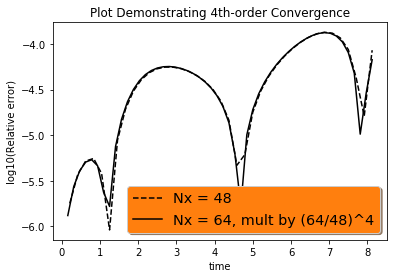

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpmath as mp
import csv

def file_reader(filename):
    with open(filename) as file:
        reader = csv.reader(file, delimiter=" ")
        data  = list(zip(*reader))
        # data is a tuple of strings. Tuples are immutable, and we need to perform math on
        #   the data, so here we convert tuple to lists of floats:
        data0 = []
        data1 = []
        for i in range(len(data[0])):
            data0.append(float(data[0][i]))
            data1.append(float(data[1][i]))
        return data0,data1
    
first_col48,second_col48 = file_reader('out48.txt')
first_col64,second_col64 = file_reader('out64.txt')

for i in range(len(second_col64)):
    # data64 = data48*(64/48)**4 
    # -> log10(data64) = log10(data48) + 4*log(64/48)
    second_col64[i] += 4*mp.log10(64./48.)

# https://matplotlib.org/gallery/text_labels_and_annotations/legend.html#sphx-glr-gallery-text-labels-and-annotations-legend-py        
fig, ax = plt.subplots()

plt.title("Plot Demonstrating 4th-order Convergence")
plt.xlabel("time")
plt.ylabel("log10(Relative error)")

ax.plot(first_col48, second_col48, 'k--', label='Nx = 48')
ax.plot(first_col64, second_col64, 'k-', label='Nx = 64, mult by (64/48)^4')
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C1')
plt.show()